### Installing necessary dependencies

In [ ]:
# %pip install pytorch_lightning lightning_utilities torchmetrics tqdm pyyaml matplotlib seaborn

In [ ]:
# %pip install nvidia-dali-cuda120 

In [3]:
import glob 
import os
import numpy as np
import time

import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline
from nvidia.dali.plugin.pytorch import (
    DALIGenericIterator as PyTorchIterator,
)

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.io import decode_image, decode_jpeg
from torch.utils.data import DataLoader, Dataset

from PIL import Image
from random import shuffle

from matplotlib import pyplot as plt

### Creating random images jpeg

In [4]:
def generate_random_images(num_images=1000, width=1024, height=1024, folder='photo_folder', extension='jpeg'):
    # Create the output folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)

    for i in range(num_images):
        # Generate an array of random pixel data
        data = np.random.randint(0, 256, (height, width, 3), dtype=np.uint8)
        # Create an image from the random data
        img = Image.fromarray(data, 'RGB')
        # Define the image filename
        img_path = os.path.join(folder, f"image_{i+1}.{extension}")
        # Save the image in JPEG format
        img.save(img_path, extension)
        print(f"Saved {img_path}")

# generate_random_images(folder='photo_folder_png', extension='png')
# generate_random_images(folder='photo_folder_jpeg', extension='jpeg')

### Defining reader for our image dataset

In [5]:
class ExternalInputIterator():
    def __init__(self, batch_size, device_id, num_gpus, folder_path, extension):
        self.files = glob.glob(f'{folder_path}/*.{extension}')
        self.batch_size = batch_size
        # whole data set size
        self.data_set_len = len(self.files)
        # based on the device_id and total number of GPUs - world size
        # get proper shard
        self.files = self.files[
            self.data_set_len
            * device_id
            // num_gpus : self.data_set_len
            * (device_id + 1)
            // num_gpus
        ]
        self.n = len(self.files)

    def __iter__(self):
        self.i = 0
        shuffle(self.files)
        return self

    def __next__(self):
        batch = []

        if self.i >= self.n:
            self.__iter__()
            raise StopIteration

        for _ in range(self.batch_size):
            jpeg_filename = self.files[self.i % self.n]

            batch.append(
                np.fromfile(jpeg_filename, dtype=np.uint8)
            )  # we can use numpy
            self.i += 1
        return (batch, )

    def __len__(self):
        return self.data_set_len

### NVIDIA-DALI

In [6]:
def get_nvidia_dali_loader(folder_path, extension='jpeg', batch_size=10):
    eii = ExternalInputIterator(batch_size, 0, 1, folder_path, extension)

    def ExternalSourcePipeline(batch_size, num_threads, device_id, external_data):
        pipe = Pipeline(batch_size, num_threads, device_id)
        with pipe:
            jpegs = fn.external_source(
                source=external_data, num_outputs=1, dtype=types.UINT8
            )
            images = fn.decoders.image(jpegs, device="mixed")
            images = fn.resize(images, resize_x=1024, resize_y=1024)
            output = fn.normalize(images, mean=0, stddev=255)
            output = fn.cast(output, dtype=types.FLOAT16)
            pipe.set_outputs(output)
        return pipe

    pipe = ExternalSourcePipeline(
        batch_size=batch_size, num_threads=batch_size, device_id=0, external_data=eii
    )
    pii = PyTorchIterator(
        pipe, ["data"]
    )
    return pii

### Standard Pytorch loading

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, root, extension='jpeg', transform=None):
        """
        Args:
            root (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root = root
        self.transform = transform
        # List only image files (you can adjust the extensions if needed)
        self.image_files = [f for f in os.listdir(root) if f.lower().endswith((f'.{extension}'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get the image file path
        img_path = os.path.join(self.root, self.image_files[idx])
        image = decode_image(img_path, mode="RGB")
        image = TF.resize(image, size=(1024, 1024))
        # Return the image and an index (or a dummy label if needed)
        return image


### Standard pytorch dataset loading

In [8]:
def get_torch_dataloader(folder_path,  extension='jpeg', batch_size=10, device='cuda:0'):
    dataset = CustomImageDataset(root=folder_path,  extension=extension, transform=None)

    # Create DataLoader with batch size and shuffling enabled
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size, pin_memory=True, persistent_workers=True)
    return dataloader

### Defining a loader

In [9]:
def check_loader(loader, nvidia=False,  device='cuda'):
    start_time = time.time()
    for e in range(10):
        for i, images in enumerate(loader):
            if not nvidia:
                images = images.to(device, dtype=torch.float16)
        if nvidia:
            loader.reset()
        
        print(f"epoch: {e} completed")
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total execution time: {elapsed_time:.2f} seconds")

### Comparing on jpeg

In [10]:
FOLDER_PATH_JPEG = 'photo_folder_jpeg'

In [11]:
nvidia_loader_jpeg = get_nvidia_dali_loader(FOLDER_PATH_JPEG, extension='jpeg')
torch_loader_jpeg = get_torch_dataloader(FOLDER_PATH_JPEG, extension='jpeg')

In [12]:
check_loader(nvidia_loader_jpeg, nvidia=True)

epoch: 0 completed
epoch: 1 completed
epoch: 2 completed
epoch: 3 completed
epoch: 4 completed
epoch: 5 completed
epoch: 6 completed
epoch: 7 completed
epoch: 8 completed
epoch: 9 completed
Total execution time: 4.63 seconds


In [13]:
check_loader(torch_loader_jpeg)

epoch: 0 completed
epoch: 1 completed
epoch: 2 completed
epoch: 3 completed
epoch: 4 completed
epoch: 5 completed
epoch: 6 completed
epoch: 7 completed
epoch: 8 completed
epoch: 9 completed
Total execution time: 55.24 seconds


Difference is significant -- nvidia-dali is faster by 5 times

### Comparing on png

In [14]:
FOLDER_PATH_PNG = 'photo_folder_png'

In [15]:
nvidia_loader_png = get_nvidia_dali_loader(FOLDER_PATH_PNG, extension='png')
torch_loader_png = get_torch_dataloader(FOLDER_PATH_PNG, extension='png')

In [16]:
check_loader(nvidia_loader_png, nvidia=True)

epoch: 0 completed
epoch: 1 completed
epoch: 2 completed
epoch: 3 completed
epoch: 4 completed
epoch: 5 completed
epoch: 6 completed
epoch: 7 completed
epoch: 8 completed
epoch: 9 completed
Total execution time: 16.39 seconds


In [17]:
check_loader(torch_loader_png)

epoch: 0 completed
epoch: 1 completed
epoch: 2 completed
epoch: 3 completed
epoch: 4 completed
epoch: 5 completed
epoch: 6 completed
epoch: 7 completed
epoch: 8 completed
epoch: 9 completed
Total execution time: 55.12 seconds


### Visualization

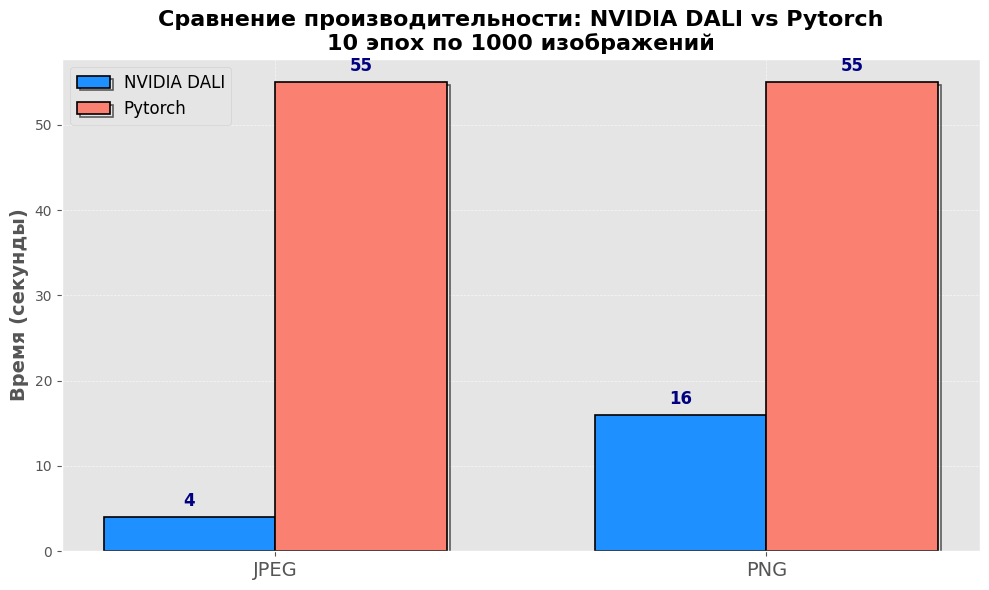

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patheffects as pe

# Используем стиль "ggplot"
plt.style.use('ggplot')

# Данные эксперимента
categories = ['JPEG', 'PNG']
dali_times = [4, 16]       # Время (секунды) для NVIDIA DALI
pytorch_times = [55, 55]   # Время (секунды) для Pytorch

# Позиции групп и ширина столбцов
x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Используем "нормальные" цвета: синий для DALI и оранжевый для Pytorch
bars_dali = ax.bar(x - width/2, dali_times, width, label='NVIDIA DALI',
                   color='dodgerblue', edgecolor='black', linewidth=1.2)
bars_pytorch = ax.bar(x + width/2, pytorch_times, width, label='Pytorch',
                      color='salmon', edgecolor='black', linewidth=1.2)

# Добавляем эффект теней к столбцам
for bar in bars_dali + bars_pytorch:
    bar.set_path_effects([pe.SimpleLineShadow(offset=(2, -2), alpha=0.6), pe.Normal()])

# Настройки подписей осей и заголовка
ax.set_ylabel('Время (секунды)', fontsize=14, fontweight='bold')
ax.set_title('Сравнение производительности: NVIDIA DALI vs Pytorch\n10 эпох по 1000 изображений', 
             fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=14)
ax.legend(fontsize=12)

# Настройка сетки
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Функция для подписей значений над столбцами
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.0f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # смещение над столбцом
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=12, fontweight='bold', color='navy')

autolabel(bars_dali)
autolabel(bars_pytorch)

plt.tight_layout()
plt.show()

### Summary